In [1]:
# https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
import matplotlib.pyplot as plt

### 01 Get the data

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### 02 Create and train the model

In [5]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
469/469 [==============================] - 15s 30ms/step - loss: 0.3183 - val_loss: 0.1441
Epoch 2/50
469/469 [==============================] - 13s 28ms/step - loss: 0.1389 - val_loss: 0.1251
Epoch 3/50
469/469 [==============================] - 13s 29ms/step - loss: 0.1238 - val_loss: 0.1179
Epoch 4/50
469/469 [==============================] - 13s 27ms/step - loss: 0.1172 - val_loss: 0.1129
Epoch 5/50
469/469 [==============================] - 12s 26ms/step - loss: 0.1136 - val_loss: 0.1096
Epoch 6/50
469/469 [==============================] - 13s 28ms/step - loss: 0.1106 - val_loss: 0.1074
Epoch 7/50
469/469 [==============================] - 12s 26ms/step - loss: 0.1083 - val_loss: 0.1057
Epoch 8/50
469/469 [==============================] - 13s 28ms/step - loss: 0.1064 - val_loss: 0.1044
Epoch 9/50
469/469 [==============================] - 13s 27ms/step - loss: 0.1048 - val_loss: 0.1030
Epoch 10/50
469/469 [==============================] - 12s 25ms/step - loss: 0.103

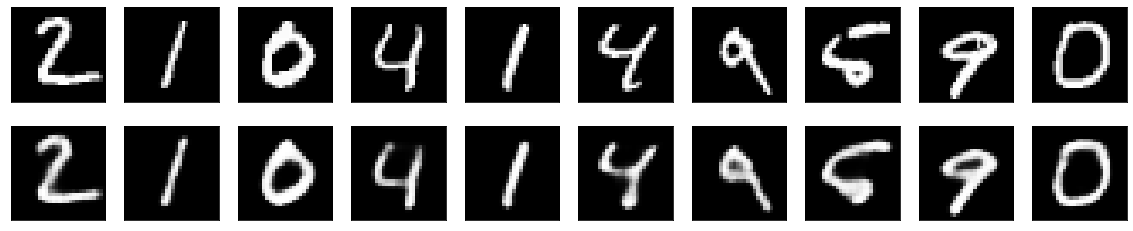

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [12]:
autoencoder.save("models/mnist/autoenc_simple.h")

INFO:tensorflow:Assets written to: models/mnist/autoenc_simple.h/assets


In [99]:
y_test[0]

7

#### 02a Save the encoder part

In [ ]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/mnist/encoder_simple.h5')

### 03 Test encoded images with a LogReg

In [17]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [23]:
# load the model from file
encoder = load_model('models/mnist/encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode.shape)



(60000, 4, 4, 8)
Shape is  (60000, 128)
Shape of encoded flat (60000, 128)
(10000, 4, 4, 8)
Shape is  (10000, 128)
Shape of encoded flat (10000, 4, 4, 8)
0.9499


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9499


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 04 Test encoded images with a CNN

In [37]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [25]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(60000, 10) (10000, 10)


#### 04b Extract features using encoder

In [28]:
# load the model from file
encoder = load_model('models/mnist/encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (60000, 4, 4, 8)
Shape of testing encoded images (10000, 4, 4, 8)


In [29]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(4, 4, 8) (4, 4, 8)


### 04c create a CNN that takes encoded image as input

In [38]:
# define a CNN to make the predictions
#create model
model = Sequential()#add model layers
model.add(Conv2D(64, kernel_size=2, activation='relu', input_shape=x_train_encode[0].shape))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
num_epochs=50
history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)

loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
print("Accuracy is ",acc)



313/313 [==============================] - 0s 861us/step - loss: 0.0697 - accuracy: 0.9818
Accuracy is  0.9818000197410583


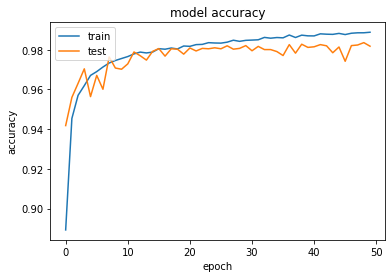

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()